In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
sentence_pairs = [
    ["hi", "salut"],
    ["how are you", "comment ça va"],
    ["i am fine", "je vais bien"],
    ["thank you", "merci"],
    ["good morning", "bonjour"]
]

In [3]:
input_sentences = [pair[0] for pair in sentence_pairs]
target_sentences = ['<start> ' + pair[1] + ' <end>' for pair in sentence_pairs]

In [4]:
input_tokenizer = Tokenizer(filters='')
input_tokenizer.fit_on_texts(input_sentences)

input_tensor = input_tokenizer.texts_to_sequences(input_sentences)
input_tensor = pad_sequences(input_tensor, padding='post')

In [5]:
target_tokenizer = Tokenizer(filters='')
target_tokenizer.fit_on_texts(target_sentences)

target_tensor = target_tokenizer.texts_to_sequences(target_sentences)
target_tensor = pad_sequences(target_tensor, padding='post')

In [6]:
print("Input tensor:\n", input_tensor)
print("Target tensor:\n", target_tensor)

input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

print("Input vocab size:", input_vocab_size)
print("Target vocab size:", target_vocab_size)


Input tensor:
 [[ 2  0  0]
 [ 3  4  1]
 [ 5  6  7]
 [ 8  1  0]
 [ 9 10  0]]
Target tensor:
 [[ 1  3  2  0  0]
 [ 1  4  5  6  2]
 [ 1  7  8  9  2]
 [ 1 10  2  0  0]
 [ 1 11  2  0  0]]
Input vocab size: 11
Target vocab size: 12


In [7]:
embedding_dim = 256
units = 512
batch_size = 2

In [8]:
BUFFER_SIZE = len(input_tensor)
steps_per_epoch = BUFFER_SIZE // batch_size

dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor))
dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)

In [9]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(enc_units, return_sequences=True, return_state=True)

    def call(self, x):
        x = self.embedding(x)
        output, state_h, state_c = self.lstm(x)
        return output, state_h, state_c

In [10]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden, cell):
        x = self.embedding(x)
        output, state_h, state_c = self.lstm(x, initial_state=[hidden, cell])
        output = self.fc(output)
        return output, state_h, state_c


In [11]:
encoder = Encoder(input_vocab_size, embedding_dim, units)
decoder = Decoder(target_vocab_size, embedding_dim, units)

In [12]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.not_equal(real, 0)
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [13]:
optimizer = tf.keras.optimizers.Adam()

In [21]:
EPOCHS = 10
epoch_losses = []

for epoch in range(EPOCHS):
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset):
        with tf.GradientTape() as tape:
            enc_output, enc_hidden, enc_cell = encoder(inp)

            dec_input = tf.expand_dims(targ[:, 0], 1)
            dec_hidden, dec_cell = enc_hidden, enc_cell


            for t in range(1, targ.shape[1]):
                pred, dec_hidden, dec_cell = decoder(dec_input, dec_hidden, dec_cell)
                loss = loss_function(targ[:, t], pred[:, 0, :])
                total_loss += loss
                dec_input = tf.expand_dims(targ[:, t], 1)


        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(total_loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))

    avg_loss = total_loss.numpy()
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Loss {avg_loss:.4f}")


Epoch 1 Loss 6.6018
Epoch 2 Loss 6.8310
Epoch 3 Loss 7.8651
Epoch 4 Loss 7.5537
Epoch 5 Loss 6.6548
Epoch 6 Loss 6.0111
Epoch 7 Loss 3.7518
Epoch 8 Loss 2.6080
Epoch 9 Loss 4.1955
Epoch 10 Loss 3.2218


In [22]:
reverse_input_word_index = {v: k for k, v in input_tokenizer.word_index.items()}
reverse_target_word_index = {v: k for k, v in target_tokenizer.word_index.items()}
target_word_index = target_tokenizer.word_index


In [23]:
def evaluate(sentence):
    sentence_seq = input_tokenizer.texts_to_sequences([sentence])
    sentence_seq = pad_sequences(sentence_seq, maxlen=input_tensor.shape[1], padding='post')

    enc_output, enc_hidden, enc_cell = encoder(sentence_seq)

    dec_input = tf.expand_dims([target_word_index['<start>']], 0)
    dec_hidden, dec_cell = enc_hidden, enc_cell

    result = []

    for _ in range(target_tensor.shape[1]):
        predictions, dec_hidden, dec_cell = decoder(dec_input, dec_hidden, dec_cell)
        predicted_id = tf.argmax(predictions[0][0]).numpy()
        predicted_word = reverse_target_word_index.get(predicted_id, '')

        if predicted_word == '<end>':
            break

        result.append(predicted_word)
        dec_input = tf.expand_dims([predicted_id], 0)

    return ' '.join(result)

In [24]:
test_sentences = [
    "hi",
    "how are you",
    "i am fine",
    "thank you",
    "good morning"
]

for sentence in test_sentences:
    output = evaluate(sentence)
    print(f"Input: {sentence}")
    print(f"Predicted Translation: {output}")

Input: hi
Predicted Translation: salut
Input: how are you
Predicted Translation: comment ça va
Input: i am fine
Predicted Translation: vais bien
Input: thank you
Predicted Translation: merci
Input: good morning
Predicted Translation: bonjour


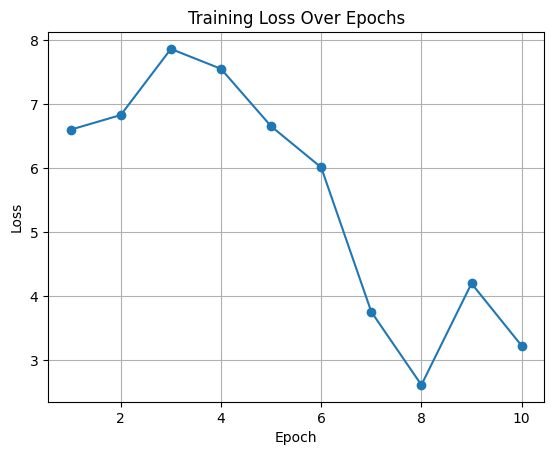

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(1, EPOCHS + 1), epoch_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
